# ISMI2018 Lymphocyte Detection Project
This is the main notebook for the final ISMI2018 project.


*Detection of lymphocytes in histopathology whole-slide images of breast, colon and prostate cancer, stained with immunohistochemistry*

### Team 6
Our group consists out of four people:
* **Brian Westerweel (Data Science)** - `B.Westerweel@student.ru.nl`
* **Christoph Schmidl (Data Science)** - `c.schmidl@student.ru.nl`
* **Gijs van der Meijde (Software Science)** - `G.vanderMeijde@student.ru.nl`
* **Jeffrey Luppus (Data Science)** - `J.Luppes@student.ru.nl`

*Supervisor: Francesco Ciompi*

Group Github page: https://github.com/jeffluppes/ISMI2018 *feel free to work in branches.*

## Goals for this week (14 to 20 may)

* Creating Masks
* Implementation of U-net structure, apply it
* Implement a patch generator
* Implement rudimentary data augmentation
* Figure out implementation of evaluation (and implement it, ;))

Be aware of the following:

* **Next contact moment**: e-mail to Francesco on Thursday. 
* **Next group meeting**: (Jeff): I'll mail Francesco on Thursday about setting one!


## Important Deadlines

* **Mid-term presentation:** June 4, 9:00 - 12:00, room 616 Huygen building
* **Final presentation:** July 2, 9:00 - 12:00, room 616 Huygen building

## Resources
The two papers Francesco sent:

* https://openreview.net/pdf?id=rk0xLisiM
* https://openreview.net/pdf?id=S10IfW2oz

Kaggle Contest about cell detection (Data Science Bowl 2018)

* https://www.kaggle.com/c/data-science-bowl-2018

Particular Kernels of Interest (KoIs)

* https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
* https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

Other resources

* https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6 (Christoph)
* https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM (Christoph)
* https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/ (Jeff)
* https://github.com/jocicmarko/ultrasound-nerve-segmentation (Jeff)
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ (Gijs)

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob
import csv
import random 
from tqdm import tqdm
from PIL import Image

# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K


# Other
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


## General introduction
TODO once more of this takes shape we should have some kind of general introduction here where we talk about the sections to come and how they relate to each other. It should be high-level and introductionary. 

In [2]:
user = 'ruc0028' #jeffrey

## If the Jupter server runs on Cartesius

In [51]:
train_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images'
validation_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images'
test_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/test_images'
train_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/training_annotations.csv'
data_dir = '/home/'+user+'/Project/data'
train_masks_dir = data_dir+'/train_masks'

### Creating Circle Masks

In [52]:
def split(x):
    return x.split(', ')

def createCircularMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
    

def createMaskForImage(img_dir, image_path, center_csv, mask_dir, radius=6):
    image_name = image_path.split('.png')[0]
    image_id, roi = image_name.split('_ROI_')
    print('Processing {}'.format(image_name))
    
    image = plt.imread(join(img_dir, image_path))
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    pois = []
    with open(center_csv) as file:
        pois = list(map(split, file.readlines()[1:]))
    
    pois = [poi for poi in pois if (poi[0] == image_id and poi[1] == roi)]

    for poi in pois:
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        shape_mask = createCircularMask(image.shape[0], image.shape[1], [x, y], radius)
        mask[shape_mask] = 1
        
    mask_image = Image.fromarray(np.uint8(mask*255), 'L')
    mask_image.save(join(mask_dir, image_name +'_mask.png'))
    print('Created a mask for: {}'.format(image_name))

In [53]:
training_paths = os.listdir(train_dir)
mask_paths = os.listdir(train_masks_dir)
for path in training_paths:
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        createMaskForImage(train_dir, path, train_points, train_masks_dir)

### Patch Generator

In [60]:
#we have THE BEST patch generator, its true, its great.

#This function generates 1 random patch from patch_amount random images.
def generate_patches(img_dir, patch_amount, width, height):
    print("Generating {} batches of {}x{} from {}/*.png".format(patch_amount,width,height,img_dir))
    patches = []
    all_img_paths = os.listdir(img_dir)
    print("{} images found.".format(len(all_img_paths)))
    img_paths = random.sample(all_img_paths, patch_amount)
    
    for img_path in img_paths:
        img = imread(join(img_dir,img_path))
        print("img {} dementions: {}".format(img_path,img.shape))
        patches.append(generate_patch(img,width,height))
        
    return patches

#This function generates a single random patch from an image.
def generate_patch(img, width, height):
    img = np.pad(img, (0 if height < img.shape[1] else height-img.shape[1] , 0 if width < img.shape[0] else width-img.shape[0]), mode='constant')
    x = random.randint(0,img.shape[0]-width+1);
    x1 = x + width
    y = random.randint(0,img.shape[1]-height+1);
    y1 = y + height
    print("patch: {}x{}".format(x,y))
    return img[x:x1,y:y1,:]

In [62]:
generate_patches(train_dir, 20, 512, 512)

Generating 20 batches of 512x512 from /projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images/*.png
413 images found.
img 95-30827-5_CD3_ROI_6.png dementions: (1202, 1850, 3)
patch: 507x877


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if sys.path[0] == '':


img 19-CD3_ROI_18.png dementions: (524, 715, 3)
patch: 2x101
img 2-CD3_ROI_4.png dementions: (731, 1094, 3)
patch: 106x173
img T10-4360_I_AG_CD3_ROI_7.png dementions: (3211, 4367, 3)
patch: 523x2130
img T17-071823_III1_CD8_ROI_3.png dementions: (750, 1180, 3)
patch: 154x209
img 1080_CD3_ROI_3.png dementions: (2424, 2598, 3)
patch: 1148x455
img 31_CD3_ROI_13.png dementions: (785, 1040, 3)
patch: 116x93
img 4_CD3_ROI_9.png dementions: (766, 842, 3)
patch: 26x81
img 35_CD8_ROI_9.png dementions: (438, 494, 3)
patch: 7x18
img T17-071823_III3_CD8_ROI_2.png dementions: (874, 1295, 3)
patch: 279x370
img T17-071823_III3_CD8_ROI_9.png dementions: (1245, 1582, 3)
patch: 459x876
img T17-071825_III4_CD3_ROI_11.png dementions: (1772, 2433, 3)
patch: 372x1343
img T10-4360_I_Y_CD8_ROI_3.png dementions: (3058, 2450, 3)
patch: 742x945
img 28_CD8_ROI_1.png dementions: (1884, 2299, 3)
patch: 323x871
img T17-071825_III7_CD8_ROI_1.png dementions: (2682, 3786, 3)
patch: 842x2653
img T3C02L1A1B1S11R01_ROI_6.p

[array([[[134, 114, 115],
         [112,  96,  97],
         [110,  96,  96],
         ..., 
         [227, 222, 226],
         [232, 228, 227],
         [243, 238, 235]],
 
        [[178, 160, 158],
         [164, 148, 148],
         [157, 143, 142],
         ..., 
         [228, 224, 225],
         [232, 228, 227],
         [242, 237, 233]],
 
        [[209, 194, 191],
         [206, 193, 187],
         [200, 189, 183],
         ..., 
         [228, 224, 225],
         [232, 228, 227],
         [242, 237, 233]],
 
        ..., 
        [[234, 236, 233],
         [239, 241, 240],
         [242, 242, 242],
         ..., 
         [248, 250, 247],
         [246, 248, 245],
         [244, 249, 245]],
 
        [[240, 242, 239],
         [238, 240, 239],
         [238, 238, 238],
         ..., 
         [247, 249, 246],
         [246, 248, 245],
         [244, 249, 245]],
 
        [[245, 247, 246],
         [238, 240, 239],
         [236, 236, 238],
         ..., 
         [247, 249, 246

## Data Augmentation

Some training examples (shape (200, 200, 3)):


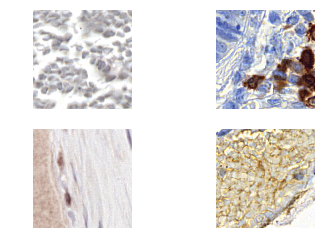

In [63]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = Image.open(input_path)
    
    
    half_the_width = image.size[0] / 2
    half_the_height = image.size[1] / 2
    image = image.crop(
        (
            half_the_width - 100,
            half_the_height - 100,
            half_the_width + 100,
            half_the_height + 100
        )
    )
    
    # Convert image to the correct range
    image = np.asarray(image) / 255

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()
    
training_paths = os.listdir(train_dir)
validation_paths = os.listdir(validation_dir)

training_images = [load_image(join(train_dir, path)) for path in training_paths[:50]]
print('Some training examples (shape {shape}):'.format(shape=training_images[0].shape))
plot_image(training_images[12:16], images_per_row=2)

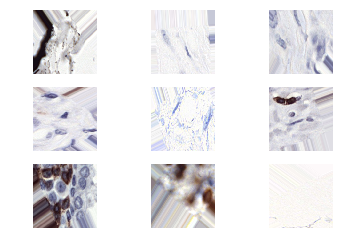

In [64]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True, 
                                     zoom_range=0.3, 
                                     width_shift_range=.3, 
                                     height_shift_range=.3)

fake_labels = np.random.rand(len(training_images))
fake_labels[fake_labels >= .5] = 1
fake_labels[fake_labels < .5] = 0

datagen.fit(training_images)

for X_batch, y_batch in datagen.flow(np.array(training_images), fake_labels, batch_size=9):
    plot_image(X_batch, images_per_row=3)
    break

### U-net architecture

In [65]:
# this is a stub.

def unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model